<a href="https://colab.research.google.com/github/carlacodes/atchekegroup1lunarlanding/blob/freddy_branch/lunar_lander_group1_atcheke_noisy_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Analysis of DQN Algorithm on the Lunar Lander task

**By Neuromatch Academy**

__Content creators:__ Raghuram Bharadwaj Diddigi, Geraud Nangue Tasse, Yamil Vidal, Sanjukta Krishnagopal, Sara Rajaee

__Content editors:__ Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

In this project, the objective is to analyze the performance of the Deep Q-Learning algorithm on an exciting task- Lunar Lander. Before we describe the task, let us focus on two keywords here - analysis and performance. What exactly do we mean by these keywords in the context of Reinforcement Learning (RL)?

---
# Setup

In [1]:
# @title Install dependencies
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet --quiet

     |████████████████████████████████| 177 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.8 MB/s 
     |████████████████████████████████| 1.5 MB 53.2 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 448 kB 5.4 MB/s 


In [2]:
# Imports
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [3]:
stable_baselines3.__version__

'1.6.0'

In [4]:
gym.__version__

'0.21.0'

In [5]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

---
# Introduction

In a standard RL setting, an agent learns optimal behavior from an environment through a feedback mechanism to maximize a given objective. Many algorithms have been proposed in the RL literature that an agent can apply to learn the optimal behavior. One such popular algorithm is the Deep Q-Network (DQN). This algorithm makes use of deep neural networks to compute optimal actions. In this project, your goal is to understand the effect of the number of neural network layers on the algorithm's performance. The performance of the algorithm can be evaluated through two metrics - Speed and Stability. 

**Speed:** How fast the algorithm reaches the maximum possible reward. 

**Stability** In some applications (especially when online learning is involved), along with speed, stability of the algorithm, i.e., minimal fluctuations in performance, is equally important. 

In this project, you should investigate the following question:

**What is the impact of number of neural network layers on speed and stability of the algorithm?**

You do not have to write the DQN code from scratch. We have provided a basic implementation of the DQN algorithm. You only have to tune the hyperparameters (neural network size, learning rate, etc), observe the performance, and analyze. More details on this are provided below. 

Now, let us discuss the RL task we have chosen, i.e., Lunar Lander. This task consists of the lander and a landing pad marked by two flags. The episode starts with the lander moving downwards due to gravity. The objective is to land safely using different engines available on the lander with zero speed on the landing pad as quickly and fuel efficient as possible. Reward for moving from the top of the screen and landing on landing pad with zero speed is between 100 to 140 points. Each leg ground contact yields a reward of 10 points. Firing main engine leads to a reward of -0.3 points in each frame. Firing the side engine leads to a reward of -0.03 points in each frame. An additional reward of -100 or +100 points is received if the lander crashes or comes to rest respectively which also leads to end of the episode. 

The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

The actions of the agents are:
  1. Do Nothing
  2. Fire Main Engine
  3. Fire Left Engine
  4. Fire Right Engine


<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/lunar_lander.png">

---
# Optimal Hyperparameters (supposedly)

Optimal hyperparameters for DQN algorithm performance on the lunar lander environment. Taken from https://huggingface.co/sb3/dqn-LunarLander-v2. Some dictionary entries might be specific to the rl-baselines-3-zoo package.

Note that other RL algorithms perform better than DQN https://github.com/DLR-RM/rl-baselines3-zoo.

In [6]:


optimal_hyperparameters = dict([('batch_size', 128),
                                      ('buffer_size', 50000),
                                      ('exploration_final_eps', 0.1),
                                      ('exploration_fraction', 0.12),
                                      ('gamma', 0.99),
                                      ('gradient_steps', -1),
                                      ('learning_rate', 0.00063),
                                      ('learning_starts', 0),
                                      ('n_timesteps', 100000.0), #for training 
                                      ('policy', 'MlpPolicy'),
                                      #('policy_kwargs', 'dict(net_arch=[256, 256])'),
                                      ('policy_kwargs', dict(net_arch=[256, 256], activation_fn=torch.nn.ReLU)), #implied that relu is used (https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html)
                                      ('target_update_interval', 250),
                                      ('train_freq', 4),
                                      #('normalize', False), #normalize_images ??
                                      ])

# map dictionary entries to variables
for key,val in optimal_hyperparameters.items():
  exec(key + '=val')



In [7]:
policy_kwargs

{'activation_fn': torch.nn.modules.activation.ReLU, 'net_arch': [256, 256]}

In [8]:
#@title
#env_kwargs = {        
#        'render_mode': None,
#        'continuous': False,
#       'gravity':  -10.0,
#        'enable_wind': True, #False as default
#        'wind_power': 20.0,
#        'turbulence_power': 1.5,
#     }

In [9]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


# Create environment

env = gym.make('LunarLander-v2') #gym.make('LunarLander-v2', **env_kwargs) #
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )


# create "optimal" model
model_DQN_optimal = DQN(policy = "MlpPolicy",
            env = env,
            policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=batch_size,  #for simplicity, we are not doing batch update.
            buffer_size=buffer_size, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=learning_starts, #learning starts immediately!
            gamma=gamma, #discount facto. range is between 0 and 1.

            target_update_interval=target_update_interval, #update the target network immediately.
            train_freq= train_freq, #train the network at every step.
            exploration_fraction = exploration_fraction, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = gradient_steps, #number of gradient steps

            # additional configured hyperparams
            exploration_final_eps = exploration_final_eps,
            
            # unexpected keywords
            #n_timesteps = n_timesteps, #for training
            #normalize = normalize, #normalize_images for MlpPolicy?? ??

            # unconfigured params/arguments compared to template
            #tau = 1,  #the soft update coefficient for updating the target network
            #max_grad_norm = 10, #the maximum value for the gradient clipping
            #exploration_initial_eps = 1, #initial value of random action probability
            seed = 1, #seed for the pseudo random generators
            #verbose=0, #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.
            
            ) 

Before we train the model, let us look at an instance of Lunar Lander **before training**.  

**Note:** The following code for rendering the video is taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

In [10]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_DQN_optimal.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
test_env.close()
show_video()

# Save parameters of pre-trained model

Obsolete. Solved by other group members.


In [11]:
model_DQN_optimal.policy

DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [12]:
## function to save model parameters

import copy

def save_model_parameters(model):

  parameters_save = []
  #cnt = 0

  
  for params in model.policy.parameters():
    #print(cnt)
    print(params.shape)
    #cnt += 1
    parameters_save.append(params)

  parameters_save_deepcopy = copy.deepcopy(parameters_save)
  return parameters_save_deepcopy

In [13]:
## Save trained model parameters

parameters_pretraining = save_model_parameters(model_DQN_optimal)

torch.Size([256, 8])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([256, 8])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


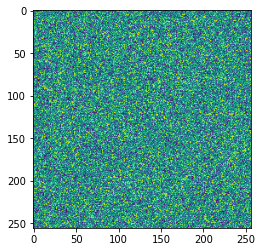

In [14]:
param_pretrain_plot = parameters_pretraining[2].cpu().detach().numpy()
plt.imshow(param_pretrain_plot)

# Train Model

In [47]:
n_timesteps

100000.0

In [15]:
callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

model_DQN_optimal.learn(total_timesteps=n_timesteps, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=-100.38 +/- 41.62
Episode length: 262.00 +/- 177.50
New best mean reward!
Eval num_timesteps=20000, episode_reward=136.96 +/- 112.43
Episode length: 767.40 +/- 289.61
New best mean reward!
Eval num_timesteps=30000, episode_reward=92.94 +/- 85.80
Episode length: 697.60 +/- 300.81
Eval num_timesteps=40000, episode_reward=262.22 +/- 17.18
Episode length: 343.60 +/- 140.68
New best mean reward!
Eval num_timesteps=50000, episode_reward=148.83 +/- 112.09
Episode length: 549.60 +/- 373.92
Eval num_timesteps=60000, episode_reward=138.83 +/- 134.98
Episode length: 368.00 +/- 132.38
Eval num_timesteps=70000, episode_reward=175.33 +/- 47.91
Episode length: 716.00 +/- 241.22
Eval num_timesteps=80000, episode_reward=230.85 +/- 25.58
Episode length: 416.40 +/- 74.19
Eval num_timesteps=90000, episode_reward=222.30 +/- 38.21
Episode length: 632.80 +/- 303.51
Eval num_timesteps=100000, episode_reward=235.35 +/- 42.25
Episode length: 455.60 +/- 97.95


In [16]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_DQN_optimal.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
test_env.close()
show_video()

233.19480119127817


Text(0, 0.5, 'Episode Rewards')

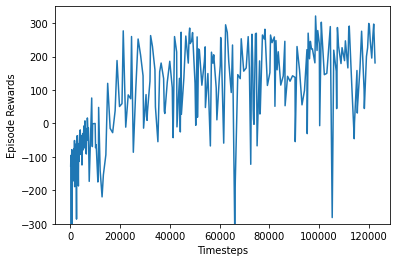

In [17]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.ylim([-300, 350])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

In [18]:
np.sum(y)

18732.603027999998

In [19]:
## Save trained model parameters

parameters_trained = save_model_parameters(model_DQN_optimal)

torch.Size([256, 8])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([256, 8])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


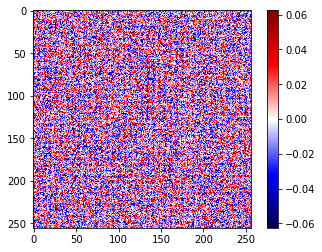

In [20]:
vmax = np.max(np.abs(param_pretrain_plot))
plt.imshow(param_pretrain_plot, cmap = 'seismic', vmin = -vmax, vmax = vmax)
plt.colorbar()

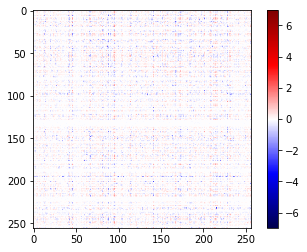

In [21]:
param_trained_plot = parameters_trained[2].cpu().detach().numpy()
vmax = np.max(np.abs(param_trained_plot))
plt.imshow(param_trained_plot, cmap = 'seismic', vmin = -vmax, vmax = vmax)
plt.colorbar()

# Performance Metrics

1. **Jumpstart**: The initial performance of an agent in a target task may be improved by transfer from a source task.
2. **Asymptotic Performance**: The final learned performance of an agent in the target task may be improved via transfer.
3. **Total Reward**: The total reward accumulated by an agent (i.e., the area under the learning curve) may be improved if it uses transfer, compared to learning without transfer.
4. **Transfer Ratio**: The ratio of the total reward accumulated by the transfer learner and the total reward accumulated by the non-transfer learner.
5. **Time to Threshold**: The learning time needed by the agent to achieve a pre-specified performance level may be reduced via knowledge transfer.
Metrics

Taken from this paper https://www.jmlr.org/papers/volume21/20-212/20-212.pdf.

In [35]:
# quick functions for agent evaluation

def jumpstart(y):
  return(y[0])

def asymptotic_performance(y, rolling_avg = 1):
  asymptotic_performance = np.mean(y[-rolling_avg:])
  return asymptotic_performance

def total_reward_fnc(y):
  return np.sum(y)

def transfer_ratio(y_transfer, y_reference):
  transfer_ratio = total_reward(y_transfer)/total_reward(y_reference)
  return transfer_ratio

def time_to_threshold(y, threshold = 275):
  return np.argmax(y > threshold)

def max_reward_fnc(y):
  return np.max(y), np.argmax(y)
  
def performance_metrics(y, rolling_avg = 10, threshold = 275):
  '''
  TODO: write plots functions
  '''

  max_reward, idx_training_max = max_reward_fnc(y)
  total_reward = total_reward_fnc(y)
  n_timesteps = len(y)
  reward_per_timestep = total_reward/n_timesteps
  asymptote = asymptotic_performance(y, rolling_avg = rolling_avg)
  std_asymptote = np.std(y[-rolling_avg:])
  asymptote_after_max = asymptotic_performance(y, rolling_avg = n_timesteps - idx_training_max)
  std_asymptote_after_max = np.std(y[-(n_timesteps - idx_training_max):])
  time_threshold = time_to_threshold(y, threshold = threshold)
  time_threshold_80_of_max = time_to_threshold(y, threshold = 0.80*max_reward)
  
  print(f" Max reward: {max_reward} \
        \n Time steps to max reward: {idx_training_max}/{n_timesteps} ({idx_training_max*100/n_timesteps:.2f}% of training period) \
        \n Total reward: {total_reward:.2f} \
        \n Reward per timestep: {reward_per_timestep:.2f} \
        \n Asymptotic performance (last {rolling_avg} timesteps): {asymptote:.2f} ±{std_asymptote:.2f} ({asymptote*100/max_reward:.2f}% of max reward) \
        \n Asymptotic performance after max: {asymptote_after_max:.2f} ±{std_asymptote_after_max:.2f} ({asymptote_after_max*100/max_reward:.2f}% of max reward) \
        \n Time to threshold(={threshold}): {time_threshold}/{n_timesteps} ({time_threshold*100/n_timesteps:.2f}% of training period) \
        \n Time to threshold(80% of max): {time_threshold_80_of_max}/{n_timesteps} ({time_threshold_80_of_max*100/n_timesteps:.2f}% of training period)" \
        )



In [46]:
performance_metrics(y, rolling_avg = 10, threshold = 225)

 Max reward: 321.204109         
 Time steps to max reward: 214/257 (83.27% of training period)         
 Total reward: 18732.60         
 Reward per timestep: 72.89         
 Asymptotic performance (last 10 timesteps): 224.05 ±72.64 (69.75% of max reward)         
 Asymptotic performance after max: 180.15 ±118.00 (56.09% of max reward)         
 Time to threshold(=225): 86/257 (33.46% of training period)         
 Time to threshold(80% of max): 86/257 (33.46% of training period)


In [ ]:
print(f" {'Max reward' : <10} {300 : ^10}")

In [ ]:
len(y)

# Load saved parameters

In [ ]:
for params in model_DQN_optimal.policy.parameters():
  print(params)

In [ ]:
## load trained model parameters

def load_model_parameters(parameters_load):

  model = DQN(policy = "MlpPolicy",
            env = env,
            policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=batch_size,  #for simplicity, we are not doing batch update.
            buffer_size=buffer_size, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=learning_starts, #learning starts immediately!
            gamma=gamma, #discount facto. range is between 0 and 1.

            target_update_interval=target_update_interval, #update the target network immediately.
            train_freq= train_freq, #train the network at every step.
            exploration_fraction = exploration_fraction, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = gradient_steps, #number of gradient steps

            # additional configured hyperparams
            exploration_final_eps = exploration_final_eps,
            
            # unexpected keywords
            #n_timesteps = n_timesteps, #for training
            #normalize = normalize, #normalize_images for MlpPolicy?? ??

            # unconfigured params/arguments compared to template
            #tau = 1,  #the soft update coefficient for updating the target network
            #max_grad_norm = 10, #the maximum value for the gradient clipping
            #exploration_initial_eps = 1, #initial value of random action probability
            #seed = 1, #seed for the pseudo random generators
            #verbose=0, #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.
            
            ) 


  parameters_before_loading = save_model_parameters(model)

  cnt = 0
  for param in model.policy.parameters():
    #print(cnt)
    param = parameters_load[cnt]
    print(params.shape)
    cnt += 1

  parameters_after_loading = save_model_parameters(model)

  return model, parameters_before_loading, parameters_after_loading

model_test, parameters_before_loading, parameters_after_loading = load_model_parameters(parameters_trained)

In [ ]:
dir(model_test.policy)

In [ ]:
dir(model_test.policy)

In [ ]:
model_DQN_optimal.policy.register_parameter?

In [ ]:
model_DQN_optimal.policy.parameters

In [ ]:
parameters_before_loading_plot = parameters_before_loading[2].cpu().detach().numpy()
vmax = np.max(np.abs(parameters_before_loading_plot))
plt.imshow(parameters_before_loading_plot, cmap = 'seismic', vmin = -vmax, vmax = vmax)
plt.colorbar()

In [ ]:
parameters_after_loading_plot = parameters_after_loading[2].cpu().detach().numpy()
vmax = np.max(np.abs(parameters_after_loading_plot))
plt.imshow(parameters_after_loading_plot, cmap = 'seismic', vmin = -vmax, vmax = vmax)
plt.colorbar()

In [ ]:
  model_pretrained = DQN(policy = "MlpPolicy",
            env = env,
            policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=batch_size,  #for simplicity, we are not doing batch update.
            buffer_size=buffer_size, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=learning_starts, #learning starts immediately!
            gamma=gamma, #discount facto. range is between 0 and 1.

            target_update_interval=target_update_interval, #update the target network immediately.
            train_freq= train_freq, #train the network at every step.
            exploration_fraction = exploration_fraction, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = gradient_steps, #number of gradient steps

            # additional configured hyperparams
            exploration_final_eps = exploration_final_eps,
            
            # unexpected keywords
            #n_timesteps = n_timesteps, #for training
            #normalize = normalize, #normalize_images for MlpPolicy?? ??

            # unconfigured params/arguments compared to template
            #tau = 1,  #the soft update coefficient for updating the target network
            #max_grad_norm = 10, #the maximum value for the gradient clipping
            #exploration_initial_eps = 1, #initial value of random action probability
            #seed = 1, #seed for the pseudo random generators
            #verbose=0, #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.
            
            ) 
  

In [ ]:
for params in model_pretrained.policy.parameters():
    #print(cnt)
    print(params)

In [ ]:
for params in parameters_trained:
  print(params)

In [ ]:
dir(model_pretrained.policy)

In [ ]:
next(model_pretrained.policy.parameters())

# Noisy Lunar Lander

## Add Noise

In [ ]:
from itertools import zip_longest
from typing import Dict, List, Tuple, Type, Union

import gym
import torch as th
from torch import nn

from stable_baselines3.common.preprocessing import get_flattened_obs_dim, is_image_space
from stable_baselines3.common.type_aliases import TensorDict
from stable_baselines3.common.utils import get_device


class BaseFeaturesExtractor(nn.Module):
    """
    Base class that represents a features extractor.
    :param observation_space:
    :param features_dim: Number of features extracted.
    """

    def __init__(self, observation_space: gym.Space, features_dim: int = 0):
        super().__init__()
        assert features_dim > 0
        self._observation_space = observation_space
        self._features_dim = features_dim

    @property
    def features_dim(self) -> int:
        return self._features_dim

    def forward(self, observations: th.Tensor) -> th.Tensor:
        raise NotImplementedError()


class NoisyLunarLander(BaseFeaturesExtractor):
    """
    Feature extract that adds noise to the input.
    :param observation_space:
    """

    def __init__(self, observation_space: gym.Space):
        super().__init__(observation_space, get_flattened_obs_dim(observation_space))
        self.flatten = nn.Flatten()

    def forward(self, observations: th.Tensor) -> th.Tensor:
        # add noise to observations (excluding leg contact)
        #print('Adding input noise:')      
        input_noise = torch.zeros(size=observations.shape)
        input_noise[:,:6]= torch.normal(mean=0.0, std=0.005, size=(1,6))
        #print(input_noise)
        #print(input_noise.shape)
        #print('Observations:')
        #print(self.flatten(observations))
        return_array = self.flatten(observations)  + input_noise
        #print("Check noise added:")
        #print(return_array-self.flatten(observations))

        return return_array


In [ ]:
torch.normal(mean=0.0, std=0.075, size=(1,6))

tensor([[-0.0424,  0.0016, -0.0296, -0.0181, -0.1086,  0.0282]])

In [ ]:
optimal_hyperparameters = dict([('batch_size', 128),
                                      ('buffer_size', 50000),
                                      ('exploration_final_eps', 0.1),
                                      ('exploration_fraction', 0.12),
                                      ('gamma', 0.99),
                                      ('gradient_steps', -1),
                                      ('learning_rate', 0.00063),
                                      ('learning_starts', 0),
                                      ('n_timesteps', 100000.0), #for training 
                                      ('policy', 'MlpPolicy'),
                                      #('policy_kwargs', 'dict(net_arch=[256, 256])'),
                                      ('policy_kwargs', dict(net_arch=[256, 256], 
                                                          activation_fn=torch.nn.ReLU,
                                                        features_extractor_class = NoisyLunarLander,
                                                        )), #implied that relu is used (https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html)
                                      ('target_update_interval', 250),
                                      ('train_freq', 4),
                                      #('normalize', False), #normalize_images ??
                                      ])

# map dictionary entries to variables
for key,val in optimal_hyperparameters.items():
  exec(key + '=val')

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


# Create environment

env = gym.make('LunarLander-v2') #gym.make('LunarLander-v2', **env_kwargs) #
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )


# create "optimal" model
model_noisy_DQN_optimal = DQN(policy = "MlpPolicy",
            env = env,
            policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=batch_size,  #for simplicity, we are not doing batch update.
            buffer_size=buffer_size, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=learning_starts, #learning starts immediately!
            gamma=gamma, #discount facto. range is between 0 and 1.

            target_update_interval=target_update_interval, #update the target network immediately.
            train_freq= train_freq, #train the network at every step.
            exploration_fraction = exploration_fraction, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = gradient_steps, #number of gradient steps

            # additional configured hyperparams
            exploration_final_eps = exploration_final_eps,


            
            # unexpected keywords
            #n_timesteps = n_timesteps, #for training
            #normalize = normalize, #normalize_images for MlpPolicy?? ??

            # unconfigured params/arguments compared to template
            #tau = 1,  #the soft update coefficient for updating the target network
            #max_grad_norm = 10, #the maximum value for the gradient clipping
            #exploration_initial_eps = 1, #initial value of random action probability
            seed = 1, #seed for the pseudo random generators
            #verbose=0, #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.
            
            ) 

Before we train the model, let us look at an instance of Lunar Lander **before training**.  

**Note:** The following code for rendering the video is taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_noisy_DQN_optimal.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
test_env.close()
show_video()

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_noisy_DQN_optimal.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
test_env.close()
show_video()

Adding input noise:
tensor([[ 1.7671, -0.6156, -0.5627,  0.5269, -0.5705, -2.1995, -0.9929,  0.6444]])
Observations:
tensor([[-0.0062,  1.3997, -0.6319, -0.4990,  0.0072,  0.1431,  0.0000,  0.0000]])
Check noise added:
tensor([[ 1.7671, -0.6156, -0.5627,  0.5269, -0.5705, -2.1995, -0.9929,  0.6444]])
Adding input noise:
tensor([[-1.1147,  0.1986,  1.2558,  0.1159, -0.5647,  0.0208, -0.3941, -0.2413]])
Observations:
tensor([[-0.0124,  1.3895, -0.6201, -0.4549,  0.0149,  0.1532,  0.0000,  0.0000]])
Check noise added:
tensor([[-1.1147,  0.1986,  1.2558,  0.1159, -0.5647,  0.0208, -0.3941, -0.2413]])
Adding input noise:
tensor([[-1.4486,  0.3763, -1.4744,  0.9705, -2.1047, -0.4652, -0.2340,  0.5411]])
Observations:
tensor([[-0.0184,  1.3786, -0.6109, -0.4820,  0.0207,  0.1159,  0.0000,  0.0000]])
Check noise added:
tensor([[-1.4486,  0.3763, -1.4744,  0.9705, -2.1047, -0.4652, -0.2340,  0.5411]])
Adding input noise:
tensor([[ 0.7073,  0.9131, -1.1717, -0.2419, -0.8687, -0.1005, -0.7103, -0

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_noisy_DQN_optimal.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
test_env.close()
show_video()

## Train Noisy Lunar Lander

In [ ]:
callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

model_noisy_DQN_optimal.learn(total_timesteps=n_timesteps*2, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=-307.19 +/- 216.61
Episode length: 697.60 +/- 137.74
New best mean reward!
Eval num_timesteps=20000, episode_reward=-44.74 +/- 44.90
Episode length: 936.40 +/- 127.20
New best mean reward!
Eval num_timesteps=30000, episode_reward=-81.34 +/- 50.14
Episode length: 895.40 +/- 209.20
Eval num_timesteps=40000, episode_reward=-22.50 +/- 18.39
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=233.62 +/- 36.23
Episode length: 603.80 +/- 300.09
New best mean reward!
Eval num_timesteps=60000, episode_reward=219.65 +/- 55.72
Episode length: 449.60 +/- 277.15
Eval num_timesteps=70000, episode_reward=-91.35 +/- 26.64
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=192.78 +/- 89.58
Episode length: 545.60 +/- 360.78
Eval num_timesteps=90000, episode_reward=204.05 +/- 39.94
Episode length: 687.60 +/- 339.99
Eval num_timesteps=100000, episode_reward=198.33 +/- 56.60
Episode length: 613.80 +/

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_noisy_DQN_optimal.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
test_env.close()
show_video()

173.50962344022028


Text(0, 0.5, 'Episode Rewards')

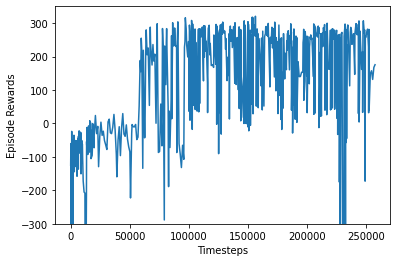

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.ylim([-300, 350])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

In [ ]:
performance_metrics(y)

 Max reward: 320.424675         
 Time steps to max reward: 419/665 (63.01% of training period)         
 Total reward: 68644.11         
 Reward per timestep: 103.22         
 Asymptotic performance (last 10 timesteps): 164.37         
 Asymptotic performance after max: 179.41 (55.99% of max reward)         
 Time to threshold(=275): 204/665 (30.68% of training period)         
 Time to threshold(80% of max): 204/665 (30.68% of training period)


## Save Noisy Lunar Lander

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/')

In [ ]:
## save the model 
dir_prefix = "/content/drive/RL_Project/"
log_dir_noisy = dir_prefix + "DQN_noisy/"
os.makedirs(log_dir_windy, exist_ok=True)
model_noisy_DQN_optimal.save(log_dir_noisy + "DQN_noisy_model.zip")



/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/RL_Project/DQN_noisy' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


OSError: ignored

In [ ]:

os.chdir(log_dir_noisy)

In [ ]:
os.getcwd()

'/content/files/DQN_noisy'

In [ ]:
os.listdir()

['DQN_noisy_model.p', 'DQN_noisy_model.zip']

In [ ]:
trained_parameters_save = model_noisy_DQN_optimal.policy.state_dict()


In [ ]:
trained_parameters_save

In [ ]:
def save_parameters(trained_parameters_save, file_name, folder):
  os.chdir(folder)
  pickle.dump(trained_parameters_save, open("DQN_noisy_model.p", "wb"))  # save it into a file named save.p

In [ ]:
import pickle


pickle.dump(trained_parameters_save, open("DQN_noisy_model.p", "wb"))  # save it into a file named save.p


## Load Noisy Lunar Lander To Standard Environment

In [ ]:
loaded_parameter = pickle.load(open("DQN_noisy_model.p", "rb"))
loaded_parameter 

OrderedDict([('q_net.q_net.0.weight',
              tensor([[ 4.3360e-01, -9.6247e-02, -9.3855e-01,  ..., -3.7892e-01,
                        3.3465e-01,  1.8872e-01],
                      [-1.1683e-01,  3.2239e-02, -1.4422e-03,  ..., -1.8552e-01,
                       -4.5310e-01,  1.6462e-01],
                      [ 5.6442e-02,  4.9744e-02,  2.1746e-01,  ..., -1.1137e+00,
                        5.6281e-03, -3.9407e-01],
                      ...,
                      [ 2.7764e-01, -4.5311e-01, -1.9313e-01,  ...,  4.8148e-01,
                        6.5013e-02,  2.0621e-01],
                      [ 2.5932e-01, -2.6220e+00,  2.8252e-01,  ..., -5.9196e-01,
                        3.4164e-01, -1.9198e-01],
                      [-9.5824e-01, -4.6825e-02, -6.6433e-01,  ...,  5.4125e-01,
                       -2.8678e-01, -6.9910e-01]])),
             ('q_net.q_net.0.bias',
              tensor([ 1.5584e-01,  2.7763e-01,  3.8701e-01,  1.0614e-01,  2.2151e-01,
                      -

In [ ]:
model1 = DQN.load(log_dir_noisy + "DQN_noisy_model.zip")

In [ ]:
model_noisy_DQN_optimal.policy.state_dict()

OrderedDict([('q_net.q_net.0.weight',
              tensor([[ 4.3360e-01, -9.6247e-02, -9.3855e-01,  ..., -3.7892e-01,
                        3.3465e-01,  1.8872e-01],
                      [-1.1683e-01,  3.2239e-02, -1.4422e-03,  ..., -1.8552e-01,
                       -4.5310e-01,  1.6462e-01],
                      [ 5.6442e-02,  4.9744e-02,  2.1746e-01,  ..., -1.1137e+00,
                        5.6281e-03, -3.9407e-01],
                      ...,
                      [ 2.7764e-01, -4.5311e-01, -1.9313e-01,  ...,  4.8148e-01,
                        6.5013e-02,  2.0621e-01],
                      [ 2.5932e-01, -2.6220e+00,  2.8252e-01,  ..., -5.9196e-01,
                        3.4164e-01, -1.9198e-01],
                      [-9.5824e-01, -4.6825e-02, -6.6433e-01,  ...,  5.4125e-01,
                       -2.8678e-01, -6.9910e-01]])),
             ('q_net.q_net.0.bias',
              tensor([ 1.5584e-01,  2.7763e-01,  3.8701e-01,  1.0614e-01,  2.2151e-01,
                      -

In [ ]:
model1.policy.state_dict()

OrderedDict([('q_net.q_net.0.weight',
              tensor([[ 4.3360e-01, -9.6247e-02, -9.3855e-01,  ..., -3.7892e-01,
                        3.3465e-01,  1.8872e-01],
                      [-1.1683e-01,  3.2239e-02, -1.4422e-03,  ..., -1.8552e-01,
                       -4.5310e-01,  1.6462e-01],
                      [ 5.6442e-02,  4.9744e-02,  2.1746e-01,  ..., -1.1137e+00,
                        5.6281e-03, -3.9407e-01],
                      ...,
                      [ 2.7764e-01, -4.5311e-01, -1.9313e-01,  ...,  4.8148e-01,
                        6.5013e-02,  2.0621e-01],
                      [ 2.5932e-01, -2.6220e+00,  2.8252e-01,  ..., -5.9196e-01,
                        3.4164e-01, -1.9198e-01],
                      [-9.5824e-01, -4.6825e-02, -6.6433e-01,  ...,  5.4125e-01,
                       -2.8678e-01, -6.9910e-01]])),
             ('q_net.q_net.0.bias',
              tensor([ 1.5584e-01,  2.7763e-01,  3.8701e-01,  1.0614e-01,  2.2151e-01,
                      -

---
# Obstacle Environment

## 2 Reward Shaping

Your objective here is to construct a modified reward function that improves the performance of the Lunar Lander. To this end, you would have to create your own custom environment. An example of a custom environment is given below:

Ref: https://towardsdatascience.com/beginners-guide-to-custom-environments-in-openai-s-gym-989371673952

### New environment

#### define new env class

In [ ]:
from gym.envs.box2d import LunarLander
from Box2D.b2 import fixtureDef, circleShape, polygonShape, revoluteJointDef, contactListener, edgeShape
import math

Set parameters

In [ ]:
FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

##### with obstacle and new reward

In [ ]:
class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
                self.env.lander == contact.fixtureA.body
                or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False

class Custom_LunarLander_obs(LunarLander):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}
    continuous = False

    def __init__(
        self,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        obs_coords = [10, 10],
        enable_obstacle: bool = True
    ):
        LunarLander.__init__(self)

        self.enable_wind = enable_wind

        self.obs_coords = obs_coords
        self.enable_obstacle = enable_obstacle
        self.wind_power = wind_power

        self.wind_idx = np.random.randint(-9999, 9999)

        # defining the polygon obstacle here:
        vertices_poly = [(5, 5), (5, 2), (2, 2), (2, 5)]  # may need to change later
        # self.obstacle = self.world.CreateStaticBody(
        #
        #     # shapes=polygonShape(centroid=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #     #                         self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #     #                    vertices= [(x / SCALE, y / SCALE) for x, y in vertices_poly]),
        #     shapes=circleShape(pos=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #                             self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #                        radius=2),
        #                         categoryBits=0x1000,
        #
        # )
        self.obstacle = self.world.CreateStaticBody(
            position=(self.obs_coords[0], self.obs_coords[1]),
            # (self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
            # self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE))
            angle=0.0,
            fixtures=fixtureDef(
                #circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape=circleShape(radius=20 / SCALE, 
                                  pos=(self.obs_coords[0],
                                       self.obs_coords[1])),
                # density=5.0,
                # friction=0.1,
                # categoryBits=0x0010,
                # # maskBits=0x001,  # collide only with ground
                # restitution=0.0,
            ),  # 0.99 bouncy
        )

        self.obstacle.color1 = (0.5, 0.4, 0.9)
        self.obstacle.color2 = (1, 1, 1)
        # self.obstacle.alpha = 0.8  

        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(10,), dtype=np.float32
        )   

    def reset(self):
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )

        # defining the polygon obstacle here----------------------------------
        vertices_poly = [(5, 5), (5, 2), (2, 2), (2, 5)]  # may need to change later
        # self.obstacle = self.world.CreateStaticBody(
        #
        #     # shapes=polygonShape(centroid=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #     #                         self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #     #                    vertices= [(x / SCALE, y / SCALE) for x, y in vertices_poly]),
        #     shapes=circleShape(pos=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #                             self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #                        radius=2),
        #                         categoryBits=0x1000,
        #
        # )
        self.obstacle = self.world.CreateStaticBody(
            position=(self.obs_coords[0], self.obs_coords[1]),
            # (self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
            # self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE))
            angle=0.0,
            fixtures=fixtureDef(
                #circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape=circleShape(radius=20 / SCALE, pos=(self.obs_coords[0],
                                       self.obs_coords[1])),
                # density=5.0,
                # friction=0.1,
                # categoryBits=0x0010,
                # # maskBits=0x001,  # collide only with ground
                # restitution=0.0,
            ),  # 0.99 bouncy
        )

        self.obstacle.color1 = (0.5, 0.4, 0.9)
        self.obstacle.color2 = (1, 1, 1)
        # self.obstacle.alpha = 0.8
        # ----------------------------------------------------------------

        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (0.5, 0.4, 0.9)
        self.lander.color2 = (0.3, 0.3, 0.5)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (0.5, 0.4, 0.9)
            leg.color2 = (0.3, 0.3, 0.5)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                        +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs
        

        return self.step(np.array([0, 0]) if self.continuous else 0)[0]

    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (
                action,
                type(action),
            )

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (
                tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            )  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        # print([pos.x,pos.y])
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2), # 0: x position
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2), # 1: y position
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS, # 2
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS, # 3
            self.lander.angle, # 4
            20.0 * self.lander.angularVelocity / FPS, # 5
            1.0 if self.legs[0].ground_contact else 0.0, # 6
            1.0 if self.legs[1].ground_contact else 0.0, # 7

            (pos.x - self.obs_coords[0] / SCALE) / (VIEWPORT_W / SCALE / 2), # 8: x position
            (pos.y - self.obs_coords[1] / SCALE) / (VIEWPORT_H / SCALE / 2), # 9: y position

        ]
        assert len(state) == 10

        # ----------------------------------------------------------------
        # reward
        # distance_to_obstacle = np.sqrt((pos.x - (self.obs_coords[0] +
        #                                     VIEWPORT_W / SCALE / 2)) ** 2 +
        #                         (pos.y - (self.obs_coords[1] +

        #                                   (self.helipad_y + LEG_DOWN / SCALE))) ** 2)
        distance_to_obstacle = np.sqrt(state[8] * state[8] + state[9] * state[9])

        # if (distance_to_obstacle <= (1)):
        #     print('dangerously close to obstacle!')

        reward = 0
        shaping = (
            # If the lander moves away from the landing pad, it loses reward
            - 100 * np.sqrt(state[0] * state[0] + state[1] * state[1]) # Euclidean distance
            - 50 * np.sqrt(state[2] * state[2] + state[3] * state[3])

            - 100 * abs(state[4])
            # Each leg with ground contact is +10 points.
            + 10 * state[6]
            + 10 * state[7]
            - 50 * (distance_to_obstacle <= (20 / SCALE)) # obstacles 
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # Firing the main engine is -0.3 points each frame. 
        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        # Firing the side engine is -0.03 points each frame.
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0: # crashed?
            done = True
            reward = -100
        if not self.lander.awake and (np.sqrt(state[0] * state[0] + state[1] * state[1]) == 0) and (np.sqrt(state[2] * state[2] + state[3] * state[3])==0): # rest
            done = True
            reward = +200

        return np.array(state, dtype=np.float32), reward, done, {}
        # ----------------------------------------------------------------


    def render(self, mode="human"):
        from gym.envs.classic_control import rendering

        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W / SCALE, 0, VIEWPORT_H / SCALE)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                max(0.2, 0.2 + obj.ttl),
                max(0.2, 0.5 * obj.ttl),
                max(0.2, 0.5 * obj.ttl),
            )
            obj.color2 = (
                max(0.2, 0.2 + obj.ttl),
                max(0.2, 0.5 * obj.ttl),
                max(0.2, 0.5 * obj.ttl),
            )

        self._clean_particles(False)
        # print('drawlist')
        # print(self.drawlist)
        for p in self.sky_polys:
            self.viewer.draw_polygon(p, color=(0, 0, 0))
        # editing below line to draw obstacle
        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans * f.shape.pos)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj.color1, filled=True
                    ).add_attr(t)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2
                    ).add_attr(t)
                    # t = rendering.Transform((100, 100))  # Position
                    # self.viewer.draw_circle(20).add_attr(t)  # Add transform for position
                    # self.viewer.render()
                else:
                    path = [trans * v for v in f.shape.vertices]
                    # print('poly shape in object fixtures')
                    # print(f)
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        for obj2 in [self.obstacle]:
            # print('rendering obstacle')
            # print(obj2)
            for f in obj2.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    # print('printing circle of radius')
                    #t = rendering.Transform(translation=trans * f.shape.pos)
                    t = rendering.Transform((self.obs_coords[0], self.obs_coords[1]))
                    # print(f.shape.radius)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj2.color1, filled=True
                    ).add_attr(t)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj2.color2, filled=False, linewidth=2
                    ).add_attr(t)
                    # t = rendering.Transform((10, 10))  # Position
                    # self.viewer.draw_circle(2).add_attr(t)  # Add transform for position
                    # self.viewer.render()
                else:
                    path = [trans * v for v in f.shape.vertices]
                    # print('poly shape in object fixtures')
                    # print(f)
                    self.viewer.draw_polygon(path, color=obj2.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj2.color2, linewidth=2)

        for x in [self.helipad_x1, self.helipad_x2]:
            flagy1 = self.helipad_y
            flagy2 = flagy1 + 50 / SCALE
            self.viewer.draw_polyline([(x, flagy1), (x, flagy2)], color=(1, 1, 1))
            self.viewer.draw_polygon(
                [
                    (x, flagy2),
                    (x, flagy2 - 10 / SCALE),
                    (x + 25 / SCALE, flagy2 - 5 / SCALE),
                ],
                color=(0.8, 0.8, 0),
            )

        return self.viewer.render(return_rgb_array=mode == "rgb_array")


    
  # def reset(self):
  #     pass  # reward, done, info can't be included

  # def render(self, mode='human'):
  #     pass

  # def close(self):
  #     pass

##### with new reward

In [ ]:
class Custom_LunarLander_reward(LunarLander):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}
    continuous = False

    def __init__(
        self,
        # render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        # EzPickle.__init__(self)
        LunarLander.__init__(self)

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        # self.wind_idx = np.random.randint(-9999, 9999)
        # self.torque_idx = np.random.randint(-9999, 9999)

        # self.screen: pygame.Surface = None
        # self.clock = None
        # self.isopen = True
        # self.world = Box2D.b2World(gravity=(0, gravity))
        # self.moon = None
        # self.lander: Optional[Box2D.b2Body] = None
        # self.particles = []

        # self.prev_reward = None

        self.continuous = continuous

        # low = np.array(
        #     [
        #         # these are bounds for position
        #         # realistically the environment should have ended
        #         # long before we reach more than 50% outside
        #         -1.5,
        #         -1.5,
        #         # velocity bounds is 5x rated speed
        #         -5.0,
        #         -5.0,
        #         -math.pi,
        #         -5.0,
        #         -0.0,
        #         -0.0,
        #     ]
        # ).astype(np.float32)
        # high = np.array(
        #     [
        #         # these are bounds for position
        #         # realistically the environment should have ended
        #         # long before we reach more than 50% outside
        #         1.5,
        #         1.5,
        #         # velocity bounds is 5x rated speed
        #         5.0,
        #         5.0,
        #         math.pi,
        #         5.0,
        #         1.0,
        #         1.0,
        #     ]
        # ).astype(np.float32)

        # # useful range is -1 .. +1, but spikes can be higher
        # self.observation_space = spaces.Box(low, high)

        # if self.continuous:
        #     # Action is two floats [main engine, left-right engines].
        #     # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
        #     # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
        #     self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        # else:
        #     # Nop, fire left engine, main engine, right engine
        #     self.action_space = spaces.Discrete(4)

        # self.render_mode = render_mode
        # self.renderer = Renderer(self.render_mode, self._render)
        

    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (
                action,
                type(action),
            )

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (
                tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            )  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2), # 0: x position
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2), # 1: y position
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS, # 2
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS, # 3
            self.lander.angle, # 4
            20.0 * self.lander.angularVelocity / FPS, # 5
            1.0 if self.legs[0].ground_contact else 0.0, # 6
            1.0 if self.legs[1].ground_contact else 0.0, # 7
        ]
        assert len(state) == 8

        # ----------------------------------------------------------------
        # reward
        reward = 0
        shaping = (
            # If the lander moves away from the landing pad, it loses reward
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1]) # Euclidean distance
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])

            - 100 * abs(state[4])
            # Each leg with ground contact is +10 points.
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # Firing the main engine is -0.3 points each frame. 
        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        # Firing the side engine is -0.03 points each frame.
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0: # crashed?
            done = True
            reward = -100
        if not self.lander.awake and (np.sqrt(state[0] * state[0] + state[1] * state[1]) == 0) and (np.sqrt(state[2] * state[2] + state[3] * state[3])==0): # rest
            done = True
            reward = +200
        return np.array(state, dtype=np.float32), reward, done, {}
        # ----------------------------------------------------------------



    
  # def reset(self):
  #     pass  # reward, done, info can't be included

  # def render(self, mode='human'):
  #     pass

  # def close(self):
  #     pass

check environment

#### register environment

In [ ]:
new_env = Custom_LunarLander_obs()
new_env

In [ ]:
from stable_baselines3.common.env_checker import check_env
check_env(new_env)

In [ ]:
from gym.envs.registration import register
# Example for the CartPole environment
register(
    # unique identifier for the env `name-version`
    id="LunarLander-v4",
    # path to the class for creating the env
    # Note: entry_point also accept a class as input (and not only a string)
    entry_point= Custom_LunarLander_obs,
    # Max number of steps per episode, using a `TimeLimitWrapper`
    max_episode_steps=1000,
)

#### define model in new env

Now, let us setup our model and the DQN algorithm. 

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v4')
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.


In [ ]:


# create "optimal" model
model_DQN_optimal_obstacle = DQN(policy = "MlpPolicy",
            env = env,
            policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=batch_size,  #for simplicity, we are not doing batch update.
            buffer_size=buffer_size, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=learning_starts, #learning starts immediately!
            gamma=gamma, #discount facto. range is between 0 and 1.

            target_update_interval=target_update_interval, #update the target network immediately.
            train_freq= train_freq, #train the network at every step.
            exploration_fraction = exploration_fraction, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = gradient_steps, #number of gradient steps

            # additional configured hyperparams
            exploration_final_eps = exploration_final_eps,
            
            # unexpected keywords
            #n_timesteps = n_timesteps, #for training
            #normalize = normalize, #normalize_images for MlpPolicy?? ??

            # unconfigured params/arguments compared to template
            #tau = 1,  #the soft update coefficient for updating the target network
            #max_grad_norm = 10, #the maximum value for the gradient clipping
            #exploration_initial_eps = 1, #initial value of random action probability
            seed = 1, #seed for the pseudo random generators
            #verbose=0, #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.
            
            ) 

Before we train the model, let us look at an instance of Lunar Lander **before training**.  

**Note:** The following code for rendering the video is taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v4"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model_DQN_optimal_obstacle.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
test_env.close()
show_video()

-25.672022025821832


#### visualize new environment

In [ ]:
new_env = wrap_env(gym.make("LunarLander-v4"))
observation = new_env.reset()
total_reward = 0

while True:
  new_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = new_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
new_env.close()
show_video()

#### train the model and visualize

In [ ]:
model_DQN_optimal_obstacle.learn(total_timesteps=200000, log_interval=10, callback=callback, eval_log_path=log_dir)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.
# how to read monitor.csv: ep_info = {"r": round(ep_rew, 6), "l": ep_len, "t": round(time.time() - self.t_start, 6)}

Eval num_timesteps=10000, episode_reward=95.48 +/- 59.92
Episode length: 869.40 +/- 261.20
New best mean reward!
Eval num_timesteps=20000, episode_reward=-41.07 +/- 7.45
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=103.18 +/- 8.94
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=4.41 +/- 65.36
Episode length: 864.60 +/- 270.80
Eval num_timesteps=50000, episode_reward=-105.94 +/- 51.58
Episode length: 124.60 +/- 18.95
Eval num_timesteps=60000, episode_reward=-116.79 +/- 116.28
Episode length: 366.80 +/- 319.34
Eval num_timesteps=70000, episode_reward=-0.51 +/- 132.91
Episode length: 490.60 +/- 415.94
Eval num_timesteps=80000, episode_reward=-61.98 +/- 106.86
Episode length: 507.60 +/- 256.54
Eval num_timesteps=90000, episode_reward=70.47 +/- 76.20
Episode length: 685.40 +/- 385.45
Eval num_timesteps=100000, episode_reward=87.48 +/- 30.92
Episode length: 830.00 +/- 340.00
Eval num_timesteps=110000, episode_reward

In [ ]:
env = wrap_env(gym.make("LunarLander-v4"))
observation = env.reset()
total_reward = 0
while True:
  env.render()
  action, _states = model_DQN_optimal_obstacle.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  total_reward += reward
  if done:
    break;

print(total_reward)
env.close()
show_video()

152.24315599746507


In [ ]:
env

<Monitor<TimeLimit<Custom_LunarLander_obs<LunarLander-v4>>>>

Text(0, 0.5, 'Episode Rewards')

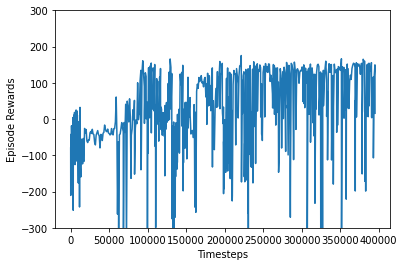

In [ ]:
x_obstacle, y_obstacle = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting. timesteps episodes
plt.plot(x_obstacle,y_obstacle)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

In [ ]:
performance_metrics(y_obstacle, rolling_avg = 10, threshold = 100)

 Total reward: -8230.226707         
 Asymptotic performance: 73.5959941         
 Time to threshold: 196


In [ ]:
perfo

In [ ]:
## Noisy input

In [ ]:
np.random.rand(3,2)

array([[0.82451863, 0.89507842],
       [0.74331846, 0.11852448],
       [0.08834934, 0.18158833]])

### Template

In [ ]:
# Taken from https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1, arg2):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # Example for using image as input (channel-first; channel-last also works):
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

  def step(self, action):
    ...
    return observation, reward, done, info
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...

As you are only changing the reward structure, you can inherit the original Lunar Lander environment from https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py and modify just the "step" function. Focus on modifying the following part of the code in the "step" function


In [ ]:
def step(self, actions):
  ...
  ...
  ...
  reward = 0
  shaping = (
      -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
      - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
      - 100 * abs(state[4])
      + 10 * state[6]
      + 10 * state[7]
  )  # And ten points for legs contact, the idea is if you
  # lose contact again after landing, you get negative reward
  if self.prev_shaping is not None:
      reward = shaping - self.prev_shaping
  self.prev_shaping = shaping

  reward -= (
      m_power * 0.30
  )  # less fuel spent is better, about -30 for heuristic landing. You should modify these values.
  reward -= s_power * 0.03

  done = False
  if self.game_over or abs(state[0]) >= 1.0:
      done = True
      reward = -100
  if not self.lander.awake:
      done = True
      reward = +100
  return np.array(state, dtype=np.float32), reward, done, {}

---
# Basic DQN Implementation

We will now implement the DQN algorithm using the existing code base. We encourage you to understand this example and re-use it in an application/project of your choice! 

Now, let us set some hyperparameters for our algorithm. This is the only part you would play around with, to solve the first part of the project. 

In [ ]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.

Now, let us setup our model and the DQN algorithm. 

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v2')
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  #for simplicity, we are not doing batch update.
            buffer_size=1, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            gamma=0.99, #discount facto. range is between 0 and 1.
            tau = 1,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 1, #initial value of random action probability
            exploration_fraction = 0.5, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1, #number of gradient steps
            seed = 1, #seed for the pseudo random generators
            verbose=0) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

Before we train the model, let us look at an instance of Lunar Lander **before training**.  

**Note:** The following code for rendering the video is taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

In [ ]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
test_env.close()
show_video()

From the video above, we see that the lander has crashed! 
It is now the time for training! 


In [ ]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

The training takes time. We encourage you to analyze the output logs (set verbose to 1 to print the output logs). The main component of the logs that you should track is "ep_rew_mean" (mean of episode rewards). As the training proceeds, the value of "ep_rew_mean" should increase. The improvement need not be monotonic, but the trend should be upwards! 

Along with training, we are also periodically evaluating the performance of the current model during the training. This was reported in logs as follows:

```
Eval num_timesteps=100000, episode_reward=63.41 +/- 130.02
Episode length: 259.80 +/- 47.47
```

Now, let us look at the visual performance of the lander. 

**Note:** The performance varies across different seeds and runs. This code is not optimized to be stable across all runs and seeds. We hope you will be able to find an optimal configuration! 

In [ ]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

The lander has landed safely!!

Let us analyze its performance (speed and stability). For this purpose, we plot the number of time steps on the X-axis and the episodic reward given by the trained model on the Y-axis. 

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

From the above plot, we observe that, although the maximum reward is achieved quickly. Achieving an episodic reward of > 200 is good. We see that the agent has achieved it in less than 50000 timesteps (speed is good!). However, there are a lot of fluctuations in the performance (stability is not good!). 

Your objective now is to modify the model parameters (nn_layers, learning_rate in the code cell #2 above), run all the cells following it and investigate the stability and speed of the chosen configuration.   


---
# Additional Project Ideas

## 1 Play with exploration-exploitation trade-off

Exploration (selecting random actions) and exploitation (selecting greedy action) is a crucial component of the DQN algorithm. Explore random actions for a long time will slow down the training process. At the same time, if all actions are not explored enough, it might lead to a sub-optimal performance. In the DQN code above, we have used the following parameters:

In [ ]:
exploration_initial_eps = 1  # initial value of random action probability. Range is between 0 and 1.
exploration_fraction = 0.5  # fraction of entire training period over which the exploration rate is reduced. Range is between 0 and 1.
exploration_final_eps = 0.05  # (set by defualt) final value of random action probability. Range is between 0 and 1.

Your objective is to play around with these parameters and analyze their performance (speed and stability). You can modify these parameters and set them as arguments in DQN(...,exploration_initial_eps = 1, exploration_fraction = 0.5, exploration_final_eps = 0.05,...). 

## 2 Reward Shaping

Your objective here is to construct a modified reward function that improves the performance of the Lunar Lander. To this end, you would have to create your own custom environment. An example of a custom environment is given below:

In [ ]:
# Taken from https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1, arg2):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # Example for using image as input (channel-first; channel-last also works):
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

  def step(self, action):
    ...
    return observation, reward, done, info
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...

As you are only changing the reward structure, you can inherit the original Lunar Lander environment from https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py and modify just the "step" function. Focus on modifying the following part of the code in the "step" function


In [ ]:
def step(self, actions):
  ...
  ...
  ...
  reward = 0
  shaping = (
      -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
      - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
      - 100 * abs(state[4])
      + 10 * state[6]
      + 10 * state[7]
  )  # And ten points for legs contact, the idea is if you
  # lose contact again after landing, you get negative reward
  if self.prev_shaping is not None:
      reward = shaping - self.prev_shaping
  self.prev_shaping = shaping

  reward -= (
      m_power * 0.30
  )  # less fuel spent is better, about -30 for heuristic landing. You should modify these values.
  reward -= s_power * 0.03

  done = False
  if self.game_over or abs(state[0]) >= 1.0:
      done = True
      reward = -100
  if not self.lander.awake:
      done = True
      reward = +100
  return np.array(state, dtype=np.float32), reward, done, {}

Once you have cutomized your own environment, you can execute that environment by just calling:

In [ ]:
#Enter the name of the custome environment you created and uncomment the line below.
#env = Custom_LunarLander()
# Refer to https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html, if you would like to create more complex environments.

## 3 Identify the state information crucial to its performance.

Your objective here is to alter the input state information and analyze the performance. The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

You can train the algorithm by masking one of the eight components at a time and understand how that affects the performance of the algorithm. Similar to the reward shaping task, you would have to create a custom environment and modify the state space. Again, you can inherit all the necessary functions and modify the following portion of the "Step" function:

In [ ]:
def step(self, actions):
  ...
  ...
  ...
  state = [ # Remove one component at a time to investigate the effect on performance!
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]

## 4 Extension to Atari Games

In the Lunar Lander task, the input to the algorithm is a vector of state information. Deep RL algorithms can also be applied when the input to the training is image frames, which is the case in the Atari games. For example, consider an Atari game - Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). To train the Pong game, you can start with the following sample code:

In [ ]:
## Taken from: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/atari_games.ipynb#scrollTo=f3K4rMXwimBO
env = make_atari_env('PongNoFrameskip-v4', n_envs=4, seed=0)

##Atari Games take a lot of memory. Following commands crash on Coalb. Run the following code on Colab Pro or your local Jupyter notebook!
# env = VecFrameStack(env, n_stack=4)
# model = DQN('CnnPolicy', env, verbose=1)  # Note the difference here! We use 'CnnPolicy" here instead of 'MlpPolicy' as the input is frames.
# model.learn(total_timesteps=1) #change the number of timesteps as desired and run this command!

## 5 Obstacle Avoidance and Transfer Learning

Your obstacle here is to add an obstacle in the path of the lunar lander (by creating a custom environment as described in point 2 above) and train the model such that the lander lands safely, avoiding collisions. 

You would first want to devise a mechansim for adding obstacles. For example, you could have an imaginary obstacle at some horizantal and vertical position cooridnates and modify the reward function such that a penalty is levied if the lander comes close to it. 

An interesting approach to solve this problem is to apply the techniques of transfer learning. For example, you could initialise the neural network model with the weights of the trained model on the original problem to improve the sample effeciency. This can be done using the following code:

In [ ]:
## Specify the load path and uncomment below:

# model = load(load_path,
#              env=gym.make('LunarLander-v2'),
#              custom_objects=None, **kwargs)

Following are some of the resources on transfer learning that you would want to start with. 

**Research Papers**

Surveys:
1. (Long, Old, Highly cited) Taylor, M. E.,  et al. (2009). Transfer learning for reinforcement learning domains. https://www.jmlr.org/papers/volume10/taylor09a/taylor09a.pdf

2. (Medium, Old, Good for a quick read) Lazaric, A. (2012). Transfer in reinforcement learning: a framework and a survey. https://hal.inria.fr/docs/00/77/26/26/PDF/transfer.pdf

3. (Medium, Recent, Good for a quick read) Zhu, Z., Lin, K., & Zhou, J. (2020). Transfer learning in deep reinforcement learning. https://arxiv.org/pdf/2009.07888.pdf

4. Specific example:
Barreto, A., et al. (2016).  Successor features for transfer in reinforcement learning. https://arxiv.org/pdf/1606.05312

## 5(b) Transfer Learning in minigrid environment

These are some simple gridworld gym environments designed to be particularly simple, lightweight and fast. Refer to https://github.com/maximecb/gym-minigrid for description of the environments. An example to load a minigrid environment is given below:

In [ ]:
!pip install gym-minigrid --quiet
import gym_minigrid
env = gym.make('MiniGrid-Empty-5x5-v0')

You can train a standard DQN agent in this env by wrapping the env with full image observation wrappers:


In [ ]:
env = gym_minigrid.wrappers.ImgObsWrapper(gym_minigrid.wrappers.RGBImgObsWrapper(env))

Note that with full image observations, the shape of the image observations may differ between envs. For e.g., MiniGrid-Empty-5x5-v0 is (40,40,3) while MiniGrid-Empty-8x8-v0 is (64,64,3). So you may need to resize the observations for transfer learning to work with the same DQN architecture.

Now try training a DQN (or another method) in one (or multiple) minigrid env(s),and see if that knowledge transfers to another (or multiple other) minigrid env(s).


## 6 Preference-Based RL (PBRL)

PBRL is an exciting sub-area in RL where the traditional reward structure is replaced with human preferences. This setting is very useful in applications where it is difficult to construct a reward function. 

In the earlier section, we have successfully trained the lunar lander to land safely. Here, the path that the lander follows to land safely can be arbitrary. In this project, using the techniques of PBRL, you will solve the lunar lander problem with an additional requirement that the lander should follow a specially curated path (for example, a straight line path). Following are some of the resources that will help you to get started with this project. 

**Research papers:**
1. Deep Reinforcement Learning
from Human Preferences https://papers.nips.cc/paper/2017/file/d5e2c0adad503c91f91df240d0cd4e49-Paper.pdf
2. Deep Q-learning from Demonstrations https://arxiv.org/pdf/1704.03732.pdf
3. Reward learning from human preferences https://arxiv.org/pdf/1811.06521.pdf
4. T-REX https://arxiv.org/pdf/1904.06387.pdf

**Code Bases:**
1. https://github.com/nottombrown/rl-teacher
2. https://github.com/hiwonjoon/ICML2019-TREX


---
# References

1. Stable Baselines Framework: https://stable-baselines3.readthedocs.io/en/master/guide/examples.html

2. Lunar Lander Environment: https://gym.openai.com/envs/LunarLander-v2/

3. OpenAI gym environments: https://gym.openai.com/docs/

4. A good reference for introduction to RL: http://incompleteideas.net/book/the-book-2nd.html
